# SAM (Segment Anything Model)

SAM과 SAM2는 Meta AI에서 발표한 최신의 Instance Segmentation 모델로, 이미지와 비디오에서 프롬프트에 따라 모든 객체를 분할해낼 수 있는 강력한 모델입니다.

Ultralytics는 SAM과 SAM2를 통합하여 분할 추론 및 자동 label 생성 기능을 제공하고 있습니다.

이번에는 SAM2 모델을 사용하여 이미지의 객체들을 분할하고, 그 결과를 바탕으로 YOLO 객체 인식 학습용 자동 라벨링을 수행하는 방법을 확인합니다.

## SAM(Segment Anything Model) 및 SAM2 소개

Segment Anything은 주어진 이미지에서 사용자가 지정한 포인트, 박스 등의 프롬프트에 대응하여 대상 객체의 정밀한 세그멘테이션 마스크를 추출하는 모델입니다.

1세대 SAM 모델은 거대한 SA-1B 데이터셋(11억 마스크)으로 학습되어 처음 보는 객체에도 제로샷으로 일반화할 수 있는 놀라운 능력을 보여주었습니다.

2024년 공개된 SAM2는 이를 확장한 버전으로, 이미지와 동영상 모두에서 동작하도록 통합되고 정확도가 더욱 향상되었습니다.

SAM2는 **실시간 처리 속도(약 44 FPS)**를 유지하면서, 복잡한 씬의 객체들을 prompt 없이도 전체 분할해낼 수 있습니다.

내부적으로 Transformer 기반의 이미지 인코더와, 프롬프트(점/박스/마스크) 인코더, 그리고 시간 정보를 활용하는 메모리 메커니즘(비디오 대응)이 추가되었습니다.

SAM이 하는 일은 객체 검출과 비슷하지만 결과 형태가 다르다는 점을 기억해야 합니다. 객체 검출은 바운딩 박스로 대상의 대략적 위치만 알려주는 반면, 세그멘테이션은 픽셀 단위로 객체의 정확한 윤곽을 제공합니다.

아래 그림을 보면, 왼쪽은 강아지의 리드줄 부분을 바운딩박스로 표시한 것이고, 오른쪽은 리드줄 부분을 마스크로 정확히 분리한 것입니다

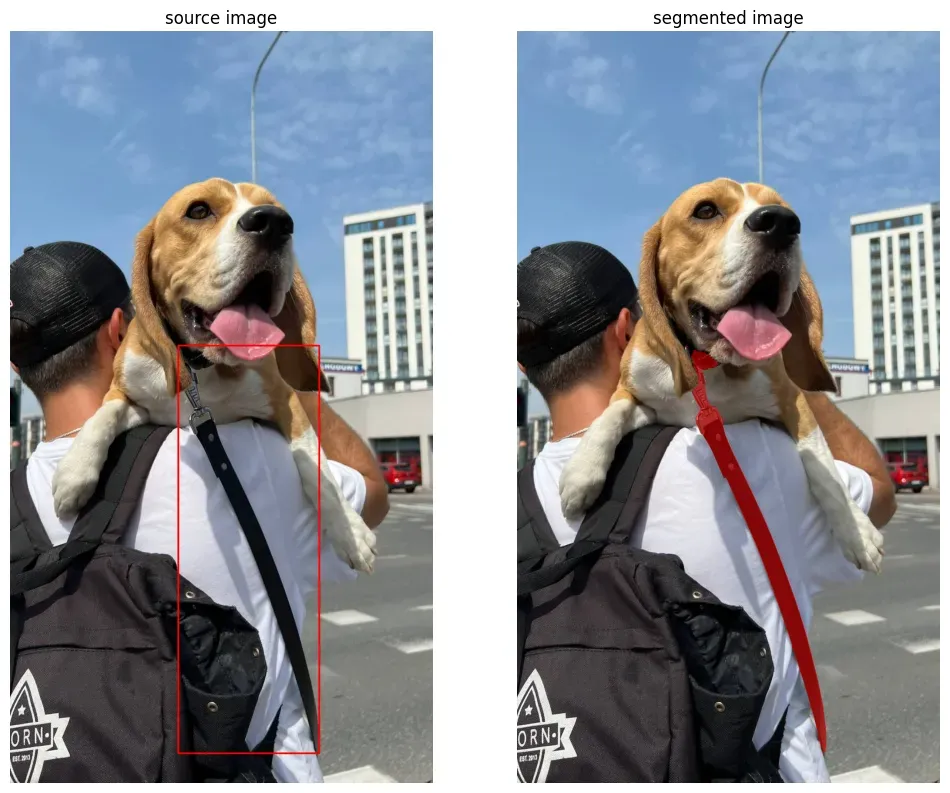

YOLO와 같은 검출 모델이 출력하는 바운딩박스는 빠르고 전역적인 정보에 적합하지만, 세그멘테이션 마스크는 정밀한 분석이나 후처리에 유리합니다.

SAM2는 이러한 마스크를 자동으로 생성해주므로, 수동 라벨링을 크게 줄일 수 있는 도구로 주목받습니다

In [1]:
!wget https://raw.githubusercontent.com/JinFree/OpenCV_for_DeepLearning/3e8b5613ff76389b78d22c35b4e30678a887aca7/Data/image_01.png

--2025-07-28 07:33:43--  https://raw.githubusercontent.com/JinFree/OpenCV_for_DeepLearning/3e8b5613ff76389b78d22c35b4e30678a887aca7/Data/image_01.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 830401 (811K) [image/png]
Saving to: ‘image_01.png’

image_01.png        100%[===================>] 810.94K  --.-KB/s    in 0.04s   

2025-07-28 07:33:43 (21.4 MB/s) - ‘image_01.png’ saved [830401/830401]



In [2]:
!pip install -qq ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 16.0 MB/s eta 0:00:00


## Ultralytics를 활용한 SAM2 추론

Ultralytics 라이브러리에서 SAM2를 사용하려면, 먼저 SAM 모델 가중치를 로드해야 합니다.

Ultralytics 허브에서 sam_b.pt(SAM base), sam2_b.pt(SAM2 base) 등의 가중치를 제공하며, 이름을 지정하면 자동 다운로드됩니다.

SAM 사용법은 YOLO와 인터페이스가 유사하지만, 입력 프롬프트를 추가로 받을 수 있다는 점이 다릅니다.

기본적으로 아무 프롬프트도 주지 않고 이미지만 넣으면 "segment everything", 즉 이미지 내 모든 객체를 분할하게 됩니다.

다음은 SAM2 모델을 이용해 이미지 전체를 분할하는 예시입니다:

In [3]:
from ultralytics import SAM

image_path = "/content/image_01.png"
model_sam = SAM("sam2_b.pt")  # SAM2 base 모델 로드 (최초 실행 시 자동 다운로드)
model_sam.info()  # 모델 정보 출력 (선택 사항)

# 프롬프트 없이 이미지 전체 분할 (Segment Everything)
results = model_sam(image_path)
masks = results[0].masks  # 분할된 마스크들
print(f"분할된 객체 수: {len(masks.data)}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 154M/154M [00:00<00:00, 233MB/s]


Model summary: 403 layers, 80,833,666 parameters, 80,833,666 gradients

image 1/1 /content/image_01.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 14007.1ms
Speed: 89.5ms preprocess, 14007.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
분할된 객체 수: 12


results 객체는 YOLO 결과와 비슷하지만, masks 속성에 각 분할 영역 정보가 들어 있습니다.

results[0].masks.data는 numpy 배열 또는 torch 텐서로 마스크들을 나타내며, shape는 (N, H, W) 또는 (N, some_encoding) 형태입니다.

Ultralytics Results는 plot() 함수로 자동 시각화도 지원합니다.

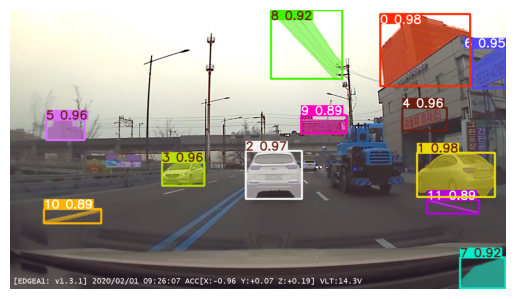

In [4]:
import matplotlib.pyplot as plt
annotated_img = results[0].plot()  # 이미지에 분할 마스크와 윤곽 그리기
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

위 코드로 출력된 이미지를 보면, 서로 다른 객체들이 각기 다른 색상으로 칠해져 있을 것입니다.

SAM2는 사람이 지목하지 않은 객체까지도 모두 분할하려고 시도하므로, 배경의 큰 영역부터 작은 물건들까지 평균 100개 내외의 마스크를 생성할 수 있습니다

만약 특정 객체만 분할하고 싶다면, 프롬프트를 제공해야 합니다.

프롬프트 방식에는 points, boxes, mask가 있으며, 예를 들어 이미지에서 (x=607,y=362)부터 (756, 489)까지의 박스 안의 물체를 세그멘트하려면 다음과 같이 합니다.


image 1/1 /content/image_01.png: 1024x1024 1 0, 296.0ms
Speed: 11.7ms preprocess, 296.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')


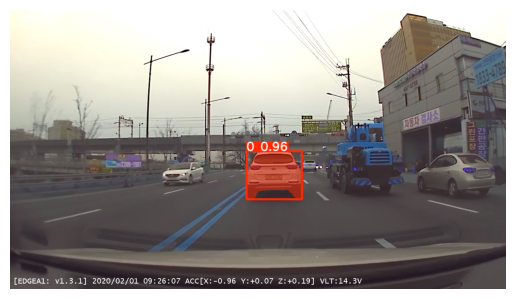

In [5]:
box = [607, 362, 756, 489]  # x1,y1,x2,y2 형식의 박스
result_box = model_sam(image_path, bboxes=[box])
mask = result_box[0].masks.data[0]  # 해당 박스에 대한 첫 번째 마스크
print(mask)
annotated_img = result_box[0].plot()  # 이미지에 분할 마스크와 윤곽 그리기
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

또는 한 점을 지정하여 그 점이 속한 객체를 분할시킬 수도 있습니다.


image 1/1 /content/image_01.png: 1024x1024 1 0, 245.1ms
Speed: 14.2ms preprocess, 245.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')


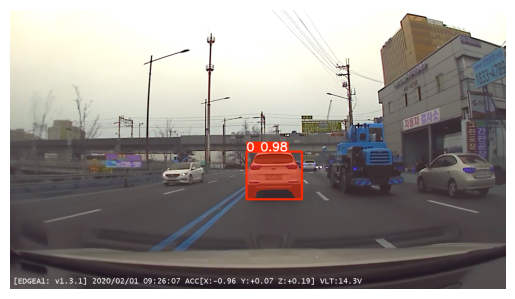

In [6]:
point = [700, 400]; label = [1]  # label 1은 긍정포인트(분할할 대상)
result_pt = model_sam(image_path, points=point, labels=label)
mask = result_pt[0].masks.data[0]
print(mask)
annotated_img = result_pt[0].plot()  # 이미지에 분할 마스크와 윤곽 그리기
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

SAM은 복수의 프롬프트도 지원하므로, 한 번에 여러 점/박스를 넣어 여러 객체를 동시에 지정할 수 있습니다.

또한 labels에 0을 주면 "이건 포함하지 말라"는 negative prompt로 작용합니다.

## SAM2 기반 Pseudo-Labeling과 자동 데이터셋 생성

이제 SAM2를 활용하여 YOLO 학습용 데이터셋을 자동으로 라벨링하는 기법을 알아보겠습니다.

이를 흔히 auto-annotation (자동 주석) 혹은 pseudo-labeling이라고 합니다. 아이디어는 간단합니다.

이미 학습된 강력한 모델(여기서는 SAM2와 YOLO 검출기)을 사용하여 라벨이 없는 이미지를 자동으로 주석 달기 해서, 그 결과를 새로운 학습 데이터로 활용하는 것입니다.

### 시나리오 1: 단독 SAM2 활용

만약 이미지 내의 모든 객체를 탐지하고 싶지만 클래스 라벨은 필요 없을 때, SAM2의 "segment everything" 기능으로 각 객체의 마스크를 얻고, 바운딩 박스로 변환하여 검출 데이터셋처럼 사용할 수 있습니다.

그러나 SAM은 무엇이 어떤 클래스인지 모른 채 모양만 분할하므로, 클래스 지정은 사람이 추가로 해야 합니다.

예를 들어, 새로운 이미지들에 대해 SAM2가 자동으로 수십 개의 마스크를 만들어 주면, 사람이 그 마스크들을 확인하며 "이건 고양이, 이건 개..." 식으로 클래스만 선택해주는 식입니다.

이 경우 바운딩 박스는 마스크의 경계로부터 쉽게 계산할 수 있습니다 (마스크 픽셀들의 x,y 최소/최대값이 박스 좌표).

이렇게 하면 라벨링 작업량을 크게 줄일 수 있습니다.

사람은 일일이 박스를 그릴 필요 없이 SAM이 제시한 마스크들에 클래스 이름만 붙이면 되기 때문입니다.

### 시나리오 2: YOLO + SAM 결합 활용

이것이 더 실용적인 방식인데, 미리 학습된 YOLO 검출기가 대략적인 바운딩박스를 예측하고, SAM이 그 박스 내부 객체를 정교하게 분할하도록 하는 것입니다.

이렇게 하면:
- YOLO가 관심 객체의 위치와 클래스를 제공합니다 (예: "개" 객체를 이 위치에 감지).
- SAM은 해당 위치의 픽셀 단위 마스크를 산출합니다 (예: 개의 정확한 영역).


두 결과를 결합하여, 우리는 정확한 마스크와 신뢰할 수 있는 클래스 라벨을 모두 얻습니다.

Ultralytics는 이 과정을 간소화한 auto_annotate 유틸리티 함수를 제공합니다.

auto_annotate(data, det_model, sam_model, ...) 형태로, 탐지 모델 경로와 SAM 모델 경로, 이미지 폴더 등을 입력합니다.

이러면 자동으로
1. YOLO 탐지 모델(det_model)로 지정한 객체들을 탐지하고,
2. 그 박스들을 SAM 모델(sam_model)에 프롬프트로 넣어 세그멘테이션을 얻은 다음,
3. 결과를 라벨 파일들로 저장합니다 (분할 라벨의 경우 polygon 또는 mask 형식으로 저장).

예를 들어, 우리가 yoloqx.pt 모델과 SAM2 base 모델을 사용하여 특정 이미지 폴더를 자동 라벨링하려면 아래와 같은 코드를 실행하면 됩니다.

```
from ultralytics.data.annotator import auto_annotate

auto_annotate(
    data="unlabeled_images/",       # 라벨링할 이미지들이 있는 폴더
    det_model="yolo11x.pt",         # 사전학습되거나 커스텀 학습된 YOLO 모델 경로
    sam_model="sam2_b.pt",          # SAM2 모델 경로
    conf=0.25, iou=0.45,            # YOLO NMS 설정 (선택)
    output_dir="unlabeled_labels/"  # 주석 출력 폴더 (기본은 images 폴더 아래 labels/)
)
```

이 함수가 완료되면, unlabeled_labels/ 폴더에 각 이미지에 대한 라벨 파일들이 생성됩니다.

세그멘테이션 데이터셋의 경우 COCO JSON이나 YOLO-seg 텍스트 형식 등이 될 수 있는데, Ultralytics에서는 YOLO-seg 포맷으로 (클래스 및 세그멘테이션 좌표) txt 파일을 저장합니다.

이러한 자동 생성 라벨은 인간이 일일이 그린 것만큼 정확하지는 않을 수 있으나, 의미 있는 pseudo-label로서 추가 학습에 활용할 수 있습니다.

YOLO 학습을 위한 활용:

분할 마스크를 얻었다면, 이를 둘러싸는 바운딩 박스를 계산해 검출 라벨로 활용할 수 있습니다.

SAM2+YOLO 조합을 쓰면 이미 클래스 정보가 있으므로, 마스크 -> 박스로 변환만 하면 바로 YOLO 검출 데이터셋으로 쓸 수 있습니다.

혹은 처음부터 YOLO-seg 형태로 학습시켜 세그멘테이션까지 하는 YOLO 모델을 만들 수도 있습니다.

예를 들어 Ultralytics YOLO에 model=yolo11n-seg.pt로 세그멘테이션 모델을 로드하고, auto_annotate로 얻은 마스크 라벨로 학습하면, 검출 + 분할을 동시에 하는 모델을 훈련할 수 있습니다.

## 실습

https://github.com/JinFree/blockbox_frames_for_object_detection

위 저장소를 git clone 한 후, 해당 폴더 내의 이미지를 임의의 yolo 모델과 sam 모델로 auto_annotate를 수행해보시오.

In [7]:
!git clone https://github.com/JinFree/blockbox_frames_for_object_detection

Cloning into 'blockbox_frames_for_object_detection'...
remote: Enumerating objects: 108, done.
remote: Total 108 (delta 0), reused 0 (delta 0), pack-reused 108 (from 1)
Receiving objects: 100% (108/108), 67.15 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [8]:
!pip install ultralytics segment-anything

In [11]:
from ultralytics import YOLO
from ultralytics.utils.autotask import auto_annotate

# YOLO 모델 로드 (VOC 학습 모델도 가능)
yolo_model = YOLO("yolov8n.pt")  # 또는 yolov11n_voc.pt 등

# SAM 모델은 ultralytics 내장된 sam_b
sam_model = 'sam_b'  # 기본 옵션: 'sam_b', 'sam_l', 'sam_h'


ModuleNotFoundError: No module named 'ultralytics.utils.autotask'